## Preparing the environment

In [1]:
import os
import random
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss

from datasets import load_dataset, Dataset
import transformers
from accelerate import Accelerator

from tqdm import tqdm

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"

data_path = "../data"

In [2]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = False

#### Setting constants

In [3]:
context_length = 128

batch_size = 128
num_workers = 8
global_batch_size = 512
accumulation_steps = global_batch_size // batch_size

learning_rate = 1e-4
betas = (0.9, 0.95)
eps = 1e-8
gradient_clipping = 1.0
weight_decay = 0.1

warmup_iters = 256

train_iters = 1024
eval_save_interval = 50
val_iters = 20

model_name = "EleutherAI/pythia-14m"
model_revision = "step0"

dataset_path = "allenai/c4"
dataset_name = "realnewslike"

## Loading dataset

In [4]:
dataset = load_dataset(dataset_path, dataset_name)
dataset = dataset.with_format("torch")

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/76 [00:00<?, ?it/s]

In [5]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name, revision=model_revision)

def tokenize(data):
    outputs = tokenizer(
        data["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = list()
    # deleting samples shorter than context_length tokens
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
if os.path.exists(os.path.join(data_path, "train_dataset")):
    train_dataset = Dataset.load_from_disk(os.path.join(data_path, "train_dataset"))
else:
    train_dataset = dataset["train"].map(
        tokenize, batched=True, remove_columns=dataset["train"].column_names
    )
    train_dataset.save_to_disk(os.path.join(data_path, "train_dataset"))


if os.path.exists(os.path.join(data_path, "val_dataset")):
    val_dataset = Dataset.load_from_disk(os.path.join(data_path, "val_dataset"))
else:
    val_dataset = dataset["validation"].map(
        tokenize, batched=True, remove_columns=dataset["validation"].column_names
    )
    val_dataset.save_to_disk(os.path.join(data_path, "val_dataset"))

Loading dataset from disk:   0%|          | 0/58 [00:00<?, ?it/s]

In [7]:
val_dataset = val_dataset.select(range(len(val_dataset) // (batch_size * val_iters) * (batch_size * val_iters)))

In [8]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Training

### Full-rank Training

In [9]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)

train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              worker_init_fn=seed_worker,
                              generator=g)
val_dataloader = DataLoader(val_dataset, 
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers,
                            worker_init_fn=seed_worker,
                            generator=g,
                            drop_last=True)

In [10]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name,
                                                          revision=model_revision,
                                                          attn_implementation="flash_attention_2").to(device)

You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXForCausalLM is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator, or load the model with the `torch_dtype` argument. Example: `model = AutoModel.from_pretrained("openai/whisper-tiny", attn_implementation="flash_attention_2", torch_dtype=torch.float16)`
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes, but the current dype in GPTNeoXModel is torch.float32. You should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=betas, eps=eps, weight_decay=weight_decay)

scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_iters, num_training_steps=train_iters)

loss_fct = CrossEntropyLoss()

In [12]:
accelerator = Accelerator(mixed_precision="fp16")

model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader
)

In [13]:
def evaluate(model, val_dataloader, val_iters):
    model.eval()
    val_losses = list()
    for step, batch in enumerate(val_dataloader):
        with torch.inference_mode():
            outputs = model(batch["input_ids"], labels=batch["input_ids"])
            val_losses.append(outputs.loss.item())
        if step + 1 >= val_iters:
            break
    val_loss = np.mean(val_losses)
    return val_loss
    

In [14]:
model.train()
train_losses = dict()
val_losses = dict()
last_losses = list()
completed_steps = 0

for step, batch in tqdm(
        enumerate(train_dataloader, start=1), total=int(train_iters * accumulation_steps)
    ):
    outputs = model(batch["input_ids"], labels=batch["input_ids"])
    loss = outputs.loss
    last_losses.append(loss.item())
    loss = loss / accumulation_steps
    accelerator.backward(loss)
    
    if step % accumulation_steps == 0:
        accelerator.clip_grad_norm_(model.parameters(), gradient_clipping)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        completed_steps += 1
    
    if step % (eval_save_interval * accumulation_steps) == 0:
        train_losses[step // accumulation_steps] = np.mean(last_losses)
        val_losses[step // accumulation_steps] = evaluate(model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[step // accumulation_steps],
                "loss/val": val_losses[step // accumulation_steps],
            }
        )
        last_losses = list()
        model.train()
        accelerator.wait_for_everyone()
    
    if step >= train_iters * accumulation_steps:
        train_losses[step // accumulation_steps] = np.mean(last_losses)
        val_losses[step // accumulation_steps] = evaluate(model, val_dataloader, val_iters)
        print(
            {
                "steps": completed_steps,
                "loss/train": train_losses[step // accumulation_steps],
                "loss/val": val_losses[step // accumulation_steps],
            }
        )
        last_losses = list()
        model.train()
        accelerator.wait_for_everyone()
        break

  5%|▍         | 202/4096 [00:25<15:23,  4.22it/s]

{'steps': 50, 'loss/train': 10.885166220664978, 'loss/val': 10.62061071395874}


 10%|▉         | 402/4096 [00:47<14:19,  4.30it/s]

{'steps': 100, 'loss/train': 10.355587420463563, 'loss/val': 10.117998456954956}


 15%|█▍        | 602/4096 [01:10<14:02,  4.14it/s]

{'steps': 150, 'loss/train': 9.898015041351318, 'loss/val': 9.655863809585572}


 20%|█▉        | 802/4096 [01:32<12:55,  4.25it/s]

{'steps': 200, 'loss/train': 9.412452306747436, 'loss/val': 9.14201054573059}


 24%|██▍       | 1002/4096 [01:54<12:18,  4.19it/s]

{'steps': 250, 'loss/train': 8.858773279190064, 'loss/val': 8.559146881103516}


 29%|██▉       | 1202/4096 [02:16<11:35,  4.16it/s]

{'steps': 300, 'loss/train': 8.285619626045227, 'loss/val': 8.031954479217529}


 34%|███▍      | 1402/4096 [02:40<13:15,  3.39it/s]

{'steps': 350, 'loss/train': 7.825999858379364, 'loss/val': 7.63286247253418}


 39%|███▉      | 1602/4096 [03:04<10:09,  4.09it/s]

{'steps': 400, 'loss/train': 7.4879869890213016, 'loss/val': 7.3461946725845335}


 44%|████▍     | 1802/4096 [03:27<09:15,  4.13it/s]

{'steps': 450, 'loss/train': 7.266108977794647, 'loss/val': 7.185594844818115}


 49%|████▉     | 2002/4096 [03:50<09:39,  3.61it/s]

{'steps': 500, 'loss/train': 7.103408036231994, 'loss/val': 7.067547488212585}


 54%|█████▍    | 2202/4096 [04:13<07:40,  4.12it/s]

{'steps': 550, 'loss/train': 6.9870149874687195, 'loss/val': 6.9291582107543945}


 59%|█████▊    | 2402/4096 [04:36<06:53,  4.10it/s]

{'steps': 600, 'loss/train': 6.894587461948395, 'loss/val': 6.847076892852783}


 64%|██████▎   | 2602/4096 [05:00<06:14,  3.99it/s]

{'steps': 650, 'loss/train': 6.81237556219101, 'loss/val': 6.807952213287353}


 68%|██████▊   | 2802/4096 [05:23<05:12,  4.14it/s]

{'steps': 700, 'loss/train': 6.764360978603363, 'loss/val': 6.741623163223267}


 73%|███████▎  | 3002/4096 [05:46<04:30,  4.04it/s]

{'steps': 750, 'loss/train': 6.72034827709198, 'loss/val': 6.711744165420532}


 78%|███████▊  | 3202/4096 [06:09<03:30,  4.24it/s]

{'steps': 800, 'loss/train': 6.69672700881958, 'loss/val': 6.680058574676513}


 83%|████████▎ | 3402/4096 [06:32<02:48,  4.11it/s]

{'steps': 850, 'loss/train': 6.669410803318024, 'loss/val': 6.675804924964905}


 88%|████████▊ | 3602/4096 [06:55<01:56,  4.23it/s]

{'steps': 900, 'loss/train': 6.656713342666626, 'loss/val': 6.672156095504761}


 93%|█████████▎| 3802/4096 [07:18<01:11,  4.08it/s]

{'steps': 950, 'loss/train': 6.653813967704773, 'loss/val': 6.6677401781082155}


 98%|█████████▊| 4002/4096 [07:40<00:21,  4.42it/s]

{'steps': 1000, 'loss/train': 6.650279190540314, 'loss/val': 6.659592700004578}


100%|█████████▉| 4095/4096 [07:50<00:00,  8.71it/s]

{'steps': 1024, 'loss/train': 6.65715354681015, 'loss/val': 6.675211763381958}


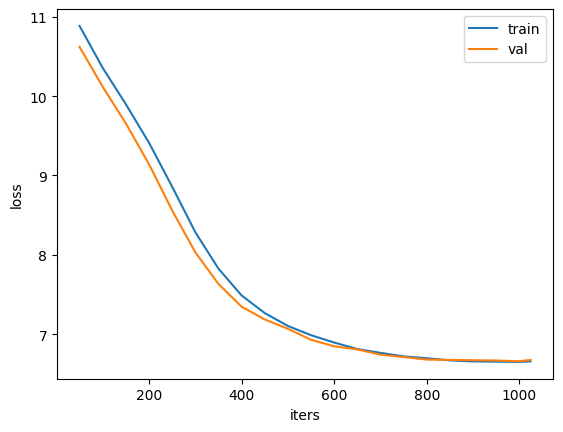

In [15]:
plt.plot(*zip(*train_losses.items()))
plt.plot(*zip(*val_losses.items()))
plt.legend(['train', 'val'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('iters')
plt.show()